# Proyecto II: De palabras a Vectores

En este proyecto vamos a implementar uno de los sistemas más utilizados par aconvertir palabras a vectores **word2vec**. En este proyecto la idea es que ustedes creén una base de datos de texto, la cúal utilizarán para entrenar la códigficación de estás palabras, y a partir de allí implementar ciertos sistemas. Par afacilitar el trabajo, en este notebook pueden encontrar unas funciones que fueron extraidas de esté [link](https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28), y adaptadas para trabajar con el lenguaje español. Sientanse libres de utilizar estas funciones o de adaptarlas asu gusto. Las funciones toman como entrada un texto en formato plano, y al finalizar entregan el vector de palabras de contexto y el vector target que puede ser utilizado para entrenar el modelo word2vec. Los datos de entrenamiento se entregan en una lista que contiene el vector de salida (codificación one hot de una palabra) y el vector que contiene la suma de los vectores hot encoded de las palabras de contexto. Para escoger el tamaño de la palabra de contexto deben modificar el parámetro $C$.

Para este proyecto necesitan realizar lo siguiente:

1. Obtengan un corpus de texto plano en Español, lo suficientemente largo, que contenga información sobre diferentes países. Este texto lo pueden extraer de wikipedia.
2. Con la información de este corpus entrenen un modelo word2vec, aquí debe seleccionar un valor $N$ que representa la longitud del vector que representará las palabras. Este modelo es una red neuronal con una sola capa oculta de $N$ neuronas.
3. Una vez tengan el modelo identifiquen la relación entre algunos países (no todos) de su corpus y sus capitales.
4. Mediante esta relación encuentren las capitales de los demás países que incluyeron en el corpus. Para esto deben realizar una búsqueda de vectores cercanos a un punto en el espacio $\mathbb{R}^{\text{N}}$. Esta búsqueda la pueden realizar con *Locally Sensitive Hashing*.
4. Realice una visualización en 2D o 3D de los vectores correspondientes a los países y sus capitales. Indicando los que usarón de referencia para encontrar la relación entre país y capital, y aquellos para los cuales no utilizarón esa relación.
5. Seleccione 5 Palabras y para ellas calcule las 10 palabras más parecidas (sinonimos) en orden de similitud.
6. Construya un nuevo corpus, más pequeño, sobre un tema cualquiera. Para este corpus necesita la versión en Español y en Ingles de los textos. Una vez más pueden utilizar Wikipedia para esto. 
7. Obtenga las representaciones en vectores par alas palabras en Español y en Ingles.
8. De los datos obtenidos, escoga un conjunto $m$ de palabras en español, y las respectiva traducción en ingles (que se encuentren en el vocabulario que construyeron) y planteé el problema de transformacion $\mathcal{X}\mathbf{R} = \mathcal{Y}$. De tal forma que encuentren la matrix de "traducción" $\mathbf{R}$.
9. Realicé esta operación para varios valores de $m$.
10. Finalmente escoja algunas palabras en Español, apliqueles la transformación $\mathbf{R}$ y liste las 5 palabras más cercanas en $\mathcal{Y}$ a esta traducción.

Al finalizar los diferentes puntos del proyecto, contesten las isguientes preguntas:

1. ¿Qué problemas tuvierón a la hora de implementar el modelo word2vec?
2. ¿Cómo escogierón el parámetro $N$?
3. ¿Qué pueden decir de los resultados del modelo buscando la relación entre los países y las capitales?
4. ¿Qué tan bien funciona el modelo para los sinonimos?, ¿Cómo creen que se puede mejorar este modelo?
5. ¿Cómo afecta el parámetro $m$ el funcionamiento del modelo de traducción?
6. ¿Cómo mejorarian el modelo de traducción?
7. ¿Qué concluyen de este proyecto y de los resultados obtenidos?

Al finalizar deben entregar el notebook, con los archivos de soporte (los corpus) y demás elementos que consideren necesarios. Recuerde dar respuesta a las preguntas del notebook, y comentar cada parte del proceso. El proyecto se debe entregar a más tardar el **Domingo 29 de Marzo a las 12 de la noche**.


# Solución

In [2]:
# Instalacion de libreria para el Locally Sensitive Hashing
!pip3 install lshashpy3

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Importacndo librerias necesarias

import re 
import numpy as np

# Matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Algoritmo de Locally Sensitive Hashing
import lshashpy3 as lshash

In [4]:
# Función para leer y procesar el archivo en texto plano.

def get_file_data(fname, stop_word_removal='no'):
    file_contents = []
    with open(fname,encoding="utf-8") as f:
        file_contents = f.read()
    text = []
    for val in file_contents.split('.'):
        val = re.sub(r'[,¡!¿?;-]+','.',val)
        val = re.sub(r'á','a',val)
        val = re.sub(r'é','e',val)
        val = re.sub(r'í','i',val)
        val = re.sub(r'ó','o',val)
        val = re.sub(r'ú','u',val)
        val = re.sub(r'Á','A',val)
        val = re.sub(r'É','E',val)
        val = re.sub(r'Í','I',val)
        val = re.sub(r'Ó','O',val)
        val = re.sub(r'Ú','U',val)
        val = re.sub(r'ñ','n',val)
        val = re.sub(r'Ñ','N',val)
        sent = re.findall("[A-Za-z]+", val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text.append(line)
    return text

# Función para obtener un Vocabulario en función del texto procesado

def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

# Función para generar representaciones one hot de los vectores target y del corpus

def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

# Función para generar los datos de entrenamiento para la red neuronal que representa el modelo word2vec

def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words

In [23]:
# Funcion para obtener el indice de un vector que se encuentra en la matriz D
def getIndex(D,v):
    k = np.where(D==v)[0].tolist()
    i = max(set(k),key=k.count)
    return i

# Solucion de ejercicios

# Punto 1

Para este punto se utilizará información de los países perú, nepal, brunéi, canadá, dinamarca y gambia; toda obtenida de wikipedia en los siguientes enlaces:

- Perú: https://es.wikipedia.org/wiki/Per%C3%BA
- Nepal: https://es.wikipedia.org/wiki/Nepal
- Brunéi: https://es.wikipedia.org/wiki/Brun%C3%A9i
- Canadá: https://es.wikipedia.org/wiki/Canad%C3%A1
- Dinamarca: https://es.wikipedia.org/wiki/Dinamarca
- Gambía: https://es.wikipedia.org/wiki/Gambia

Toda la información fue almacenada en el archivo paises.txt adjunta con el proyecto.

# Punto 2

In [5]:
# Leyendo el archivo paises.txt y aplicando el preprocesamiento necesario

fname = 'paises' #Nombre del archivo
C = 2 # Número de palabras de contexto a la derecha y a la izquierda
text = get_file_data(fname, stop_w
                     ord_removal='no')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,C,vocab_size,word_to_index,length_of_corpus,sample=None)

In [7]:
# Definiendo las matrices de entrada (X) y de salida (Y)
X = np.array([x[1] for x in training_data])
Y = np.array([y[0] for y in training_data])

El corpus obtenido del archivo paises.txt tiene un tamaño de 5013 y un vocabulario de 1620. De esta forma las matrices X y Y tiene  dimensiones:

In [13]:
print("Dimensiones de X: ",X.shape)
print("Dimensiones de Y: ",Y.shape)

Dimensiones de X:  (5103, 1620)
Dimensiones de Y:  (5103, 1620)


Para la definición de la red neuronal se utilizó la arquitectura planteada en clase y se utilizó un $N=100$ para la capa intermedia

In [14]:
# Definiendo arquitectura de la red neuronal
model = Sequential()  
model.add(Dense(100,input_shape=(vocab_size,), activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy'])  

In [15]:
# Entrenando la red
model.fit(X,Y,epochs=50)

Epoch 1/50
160/160 [==============================] - 1s 5ms/step - loss: 6.7439 - accuracy: 0.0841
Epoch 2/50
160/160 [==============================] - 1s 5ms/step - loss: 5.9854 - accuracy: 0.0858
Epoch 3/50
160/160 [==============================] - 1s 5ms/step - loss: 5.7775 - accuracy: 0.0878
Epoch 4/50
160/160 [==============================] - 1s 5ms/step - loss: 5.6256 - accuracy: 0.1013
Epoch 5/50
160/160 [==============================] - 1s 5ms/step - loss: 5.4853 - accuracy: 0.1117
Epoch 6/50
160/160 [==============================] - 1s 5ms/step - loss: 5.3592 - accuracy: 0.1186
Epoch 7/50
160/160 [==============================] - 1s 5ms/step - loss: 5.2358 - accuracy: 0.1252
Epoch 8/50
160/160 [==============================] - 1s 5ms/step - loss: 5.1193 - accuracy: 0.1325
Epoch 9/50
160/160 [==============================] - 1s 5ms/step - loss: 5.0059 - accuracy: 0.1370
Epoch 10/50
160/160 [==============================] - 1s 5ms/step - loss: 4.8930 - accuracy: 0.1440

Para la representación de las palabras se utilizará la matriz del promedio, definida como $D$, entre las matrices de pesos $W_1$ y $W_2$

In [18]:
# Obteniendo representaciones de los vectores con las matrices de pesos de la red
W1 = model.get_weights()[0]
W2 = model.get_weights()[2]
D = 0.5*(W2.T+W1)

# Punto 3: Calculando relaciones entre paises y capitales

Para encontrar la relación entre los paises y sus capitales primero se buscó el índice correspondiente a los nombres de los paises y las capitales en el corpus.

In [19]:
# Obteniendo indices de los vectores que representan los paises y capitales
peru_index      = word_to_index['peru']
lima_index      = word_to_index['lima']

nepal_index     = word_to_index['nepal']
katmandu_index  = word_to_index['katmandu']

brunei_index    = word_to_index['brunei']
bandar_index    = word_to_index['bandar']

canada_index    = word_to_index['canada']
ottawa_index    = word_to_index['ottawa']

dinamarca_index = word_to_index['dinamarca']
copenhague_index = word_to_index['copenhague']

gambia_index    = word_to_index['gambia']
banjul_index    = word_to_index['banjul'] 

Teniendo ya los índices se busca la representación en vector correspondiente a cada país y capital

In [20]:
# Obteniendo los vectores que representan los paises y capitales
peru = D[peru_index]
lima = D[lima_index]

nepal = D[nepal_index]
katmandu = D[katmandu_index]

brunei = D[brunei_index]
bandar = D[bandar_index]

canada = D[canada_index]
ottawa = D[ottawa_index]

dinamarca = D[dinamarca_index]
copenhague = D[copenhague_index]

gambia = D[gambia_index]
banjul = D[banjul_index]

Para obtener el mejor resultado, calculamos el vector de diferencia de 5 de los 6 paíes, y posteriormente calculamos el promedio entre los 5. De esta forma se obtiene un vector, denominado como **capital**, el cual será el vector representativo de las relaciones entre países y capítales

In [21]:
# Calculando relaciones entre paises y capitales

r_peru   = peru-lima
r_nepal  = nepal- katmandu
r_brunei = brunei-bandar
r_canada = canada-ottawa
r_dinamarca = dinamarca-copenhague

# Vector representativo
capital = np.array([r_peru,r_nepal,r_brunei,r_canada,r_dinamarca]).mean(axis=0)

# Punto 4: Locally Sensitive Hashing

Para obtener las palabras del corpus que son más parecidas a las capitales que buscamos, utilizamos el algoritmo de **Locally Sensitive Hashing** implementado en la librería lshashpy3 la cual se encuentra en: https://pypi.org/project/lshashpy3/

En este caso se crean 4 hiperplanos sobre vectores de dimension 100 (vectores de la matriz $D$) y se aplican 10 repeticiones aleatorias. Esto último para obtener los mejores resultados.

In [78]:
# Modelo con 4 divisiones y vectores de R^100
lsh = lshash.LSHash(4, 100,num_hashtables=10)

# Ingresamos todos los vectores del corpus (vectores fila de la matriz D), para alimentar al algoritmo
for word in D:
    lsh.index(word)

Finalmnete por cada uno de los 6 países se les aplica la operación:
$$capital\_del\_pais = pais + capital$$

en donde $capital$ es el vector representativo anteriormente calculado. Después se realiza la búsqueda de los vectores del corpus más cercanos utilizando el algoritmo de locally sensitive hashing y se verifica si la capital correspondiente si se encuentra en ese conjunto.

### Peru

In [79]:
# Consultando vector en el modelo
capital_del_pais = peru+capital
nn = lsh.query(list(capital_del_pais), distance_func="cosine")

# Verificando que existe
palabras_cercanas = [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]
print('lima está entre las más cercanas? '+('si' if 'lima' in palabras_cercanas else 'no'))  

lima está entre las más cercanas? si


### Nepal

In [80]:
# Consultando vector en el modelo
capital_del_pais = nepal+capital
nn = lsh.query(list(capital_del_pais), distance_func="cosine")

# Verificando que existe
palabras_cercanas = [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]
print('katmandu está entre las más cercanas? '+('si' if 'katmandu' in palabras_cercanas else 'no'))  

katmandu está entre las más cercanas? si


### Brunei

In [81]:
# Consultando vector en el modelo
capital_del_pais = brunei+capital
nn = lsh.query(list(capital_del_pais), distance_func="cosine")

# Verificando que existe
palabras_cercanas = [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]
print('bandar está entre las más cercanas? '+('si' if 'bandar' in palabras_cercanas else 'no'))  

bandar está entre las más cercanas? si


### Canada

In [82]:
# Consultando vector en el modelo
capital_del_pais = canada+capital
nn = lsh.query(list(capital_del_pais), distance_func="cosine")

# Verificando que existe
palabras_cercanas = [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]
print('ottawa está entre las más cercanas? '+('si' if 'ottawa' in palabras_cercanas else 'no'))  

ottawa está entre las más cercanas? si


### Dinamarca

In [83]:
# Consultando vector en el modelo
capital_del_pais = dinamarca+capital
nn = lsh.query(list(capital_del_pais), distance_func="cosine")

# Verificando que existe
palabras_cercanas = [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]
print('copenhague está entre las más cercanas? '+('si' if 'copenhague' in palabras_cercanas else 'no'))  

copenhague está entre las más cercanas? si


### Gambia

In [84]:
# Consultando vector en el modelo
capital_del_pais = gambia+capital
nn = lsh.query(list(capital_del_pais), distance_func="cosine")

# Verificando que existe
palabras_cercanas = [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]
print('banjul está entre las más cercanas? '+('si' if 'banjul' in palabras_cercanas else 'no'))  

banjul está entre las más cercanas? no


# Punto 5: Graficando vectores de paises y capitales con PCA

Para poder ver de forma gráfica las relaciones entre los vectores de los paises y las capitales se aplicará PCA para obtener vectores de $R^2$ y $R^3$, los cuales serán graficados en sus respectivos espacios.

Primero se obtendrá una matriz, en este caso $M$, con los vectores correspondientes a los paises y las capitales.

In [86]:
M_pais = ['peru','nepal','brunei','canada','dinamarca','gambia','lima','katmandu','bandar','ottawa','copenhague','banjul']
M_indx = [word_to_index[word] for word in M_pais]
M = D[M_indx,:]

## 2D

In [87]:
# Aplicando PCA con 2 componentes
pca = PCA(n_components=2)
pca.fit(M.T)

print("Varianza explicada: ",pca.explained_variance_ratio_)

Varianza explicada:  [0.22668505 0.12307487]


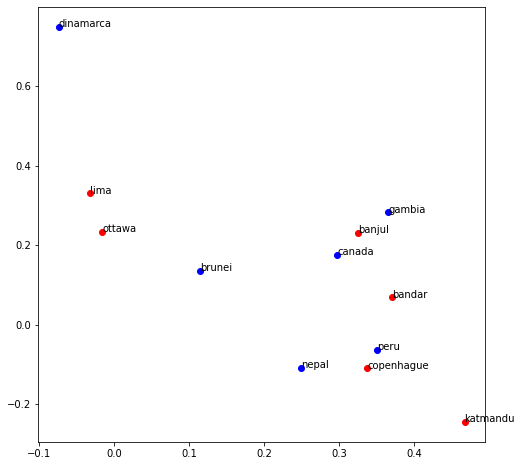

In [89]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()

x = pca.components_[0,:]
y = pca.components_[1,:]

labels = ['peru','nepal','brunei','canada','dinamarca','gambia','lima','katmandu','bandar','ottawa','copenhague','banjul']

plt.scatter(x[0:6],y[0:6],color='b')
plt.scatter(x[6:],y[6:],color='r')

for label in range(12):
    ax.text(x[label],y[label],labels[label])

## 3D

In [90]:
# Aplicando PCA con 3 componentes
pca = PCA(n_components=3)
pca.fit(M.T)

print("Varianza explicada: ",pca.explained_variance_ratio_)

Varianza explicada:  [0.22668505 0.12307487 0.11915085]


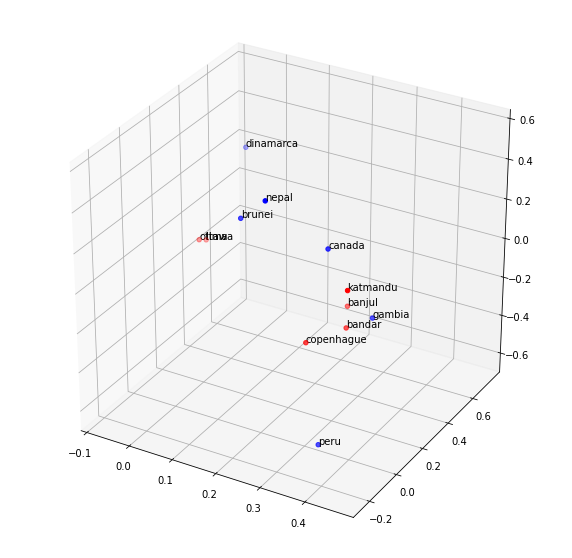

In [91]:
# Graficando las componentes de PCA
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')


labels = ['peru','nepal','brunei','canada','dinamarca','gambia','lima','katmandu','bandar','ottawa','copenhague','banjul']

# componentes de PCA
xdata = pca.components_[0,:]
ydata = pca.components_[1,:]
zdata = pca.components_[2,:]

ax.scatter3D(xdata[0:6], ydata[0:6], zdata[0:6],color='b')
ax.scatter3D(xdata[6:], ydata[6:], zdata[6:],color='r')

for label in range(12):
    ax.text(xdata[label],ydata[label],zdata[label],labels[label])

# Punto 6: Encontrando sinónimos

Para encontrar los sinonimos se tomaron 5 palabras del corpus (restos, mundo, antigua, comunidades y divide) y se aplicó el mismo algoritmo de locally sensitive hashing para encontrar las 10 palabras más cercanas.

Al igual que en el caso anterior se tomaron 4 hiperplanos para vectores de $R^{100}$ (vectores de la matriz $D$)

In [92]:
# Modelo con 4 divisiones y vectores de R^100
lsh = lshash.LSHash(4, 100)

for word in D:
    lsh.index(word)

In [93]:
# Palabras a buscar sinonimos
words = ['restos','mundo','antigua','comunidades','divide']

# Indices y vectores de las palabras
words_indx = [word_to_index[w] for w in words]
indx_vec = [D[i] for i in words_indx]

In [98]:
# Buscando las 10 palabras que mas se parecen
top = 10
for i,word in enumerate(indx_vec):
    vecinos = lsh.query(word.tolist(),num_results=top,distance_func='cosine')
    print('-> Los sinonimos de ',words[i], ' son: \n',[index_to_word[getIndex(D,vecinos[i][0][0])] for i in range(len(vecinos))])
    print("")

-> Los sinonimos de  restos  son: 
 ['restos', 'extensa', 'tratandose', 'acumulacion', 'dirigida', 'edificacion', 'longitud', 'mantenimiento', 'historiografica', 'hubo']

-> Los sinonimos de  mundo  son: 
 ['mundo', 'conquista', 'guano', 'independencia', 'peru', 'nota', 'america', 'oncenio', 'antigua', 'publica']

-> Los sinonimos de  antigua  son: 
 ['antigua', 'independencia', 'nota', 'oncenio', 'mundo', 'guano', 'sociales', 'conquista', 'centrada', 'arquitectura']

-> Los sinonimos de  comunidades  son: 
 ['comunidades', 'piezas', 'venezuela', 'arenas', 'culturas', 'alrededor', 'guerras', 'provinciales', 'ratifico', 'manila']

-> Los sinonimos de  divide  son: 
 ['divide', 'definieron', 'articula', 'codos', 'esa', 'unieron', 'zigzag', 'libro', 'sea', 'aldea']



# Punto 7 y 8: obteniendo corpus y representación de vectores

Para la traducción se buscaron varios cuentos infantiles de internet para obtener el corpus en español (archivo cuento.txt) y se utilizó el traductor de google para obtener el corpus en ingles (archivo translate_f.txt). Para cada uno se entrenó una red y se obtuvieron las correspondientes matrices de pesos para calcular la matriz promedio para español e ingles ($D\_E$ y $D\_I$, correspondientemente).

### Español

In [99]:
# Ejecución del código

fname = 'cuento.txt' #Nombre del archivo
C_E = 2 # Número de palabras de contexto a la derecha y a la izquierda
text_E = get_file_data(fname, stop_word_removal='no')
word_to_index_E,index_to_word_E,corpus_E,vocab_size_E,length_of_corpus_E = generate_dictinoary_data(text_E)
training_data_E,training_sample_words_E = generate_training_data(corpus_E,C_E,vocab_size_E,word_to_index_E,length_of_corpus_E,sample=None)

El tamaño del corpus en epañol es de 2382 y del vocabulario de 1027, por esta razón se tomo el valor $N=50$ para la capa intermedia de la red.

In [101]:
# Definiendo red neuronal
model_E = Sequential()  
model_E.add(Dense(50,input_shape=(vocab_size_E,), activation='relu'))
model_E.add(Dense(vocab_size_E, activation='softmax'))

model_E.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy'])  

In [102]:
# Matriz de entrada y de salida
X_E = np.array([x[1] for x in training_data_E])
Y_E = np.array([y[0] for y in training_data_E])

# Obteniendo un conjunto de entrenamiento y de testeo
X_train_E,X_test_E,Y_train_E,Y_test_E = train_test_split(X_E,Y_E,test_size=0.3)

# Entrenando
model_E.fit(X_train_E,Y_train_E,epochs=100,validation_data=(X_test_E,Y_test_E))

Epoch 1/100
53/53 [==============================] - 0s 8ms/step - loss: 6.8909 - accuracy: 0.0372 - val_loss: 6.8411 - val_accuracy: 0.0448
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 6.6192 - accuracy: 0.0498 - val_loss: 6.6438 - val_accuracy: 0.0420
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 6.1892 - accuracy: 0.0522 - val_loss: 6.5527 - val_accuracy: 0.0406
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 5.8979 - accuracy: 0.0516 - val_loss: 6.6855 - val_accuracy: 0.0406
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 5.7800 - accuracy: 0.0522 - val_loss: 6.8348 - val_accuracy: 0.0406
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 5.6954 - accuracy: 0.0522 - val_loss: 6.9685 - val_accuracy: 0.0406
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 5.6164 - accuracy: 0.0522 - val_loss: 7.0730 - val_accuracy: 0.0406
Epoch 8/100
5

53/53 [==============================] - 0s 5ms/step - loss: 0.3119 - accuracy: 0.9724 - val_loss: 12.4541 - val_accuracy: 0.0601
Epoch 59/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2878 - accuracy: 0.9778 - val_loss: 12.5200 - val_accuracy: 0.0629
Epoch 60/100
53/53 [==============================] - 0s 4ms/step - loss: 0.2670 - accuracy: 0.9790 - val_loss: 12.5917 - val_accuracy: 0.0587
Epoch 61/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2473 - accuracy: 0.9808 - val_loss: 12.6334 - val_accuracy: 0.0615
Epoch 62/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2288 - accuracy: 0.9802 - val_loss: 12.6984 - val_accuracy: 0.0601
Epoch 63/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2115 - accuracy: 0.9802 - val_loss: 12.7564 - val_accuracy: 0.0573
Epoch 64/100
53/53 [==============================] - 0s 4ms/step - loss: 0.1961 - accuracy: 0.9832 - val_loss: 12.8118 - val_accuracy: 0.0587
Epoch 65/100

In [105]:
# Obteniendo representaciones de los vectores con las matrices de pesos
W1 = model_E.get_weights()[0]
W2 = model_E.get_weights()[2]
D_E = 0.5*(W2.T+W1)

### Ingles

In [109]:
fname = 'translate_f.txt' #Nombre del archivo
C_I = 2 # Número de palabras de contexto a la derecha y a la izquierda
text_I = get_file_data(fname, stop_word_removal='no')
word_to_index_I,index_to_word_I,corpus_I,vocab_size_I,length_of_corpus_I = generate_dictinoary_data(text_I)
training_data_I,training_sample_words_I = generate_training_data(corpus_I,C_I,vocab_size_I,word_to_index_I,length_of_corpus_I,sample=None)

El tamaño del corpus en ingles es de 2615 y del vocabulario de 815, por esta razón se tomo el valor $N=50$ para la capa intermedia de la red.

In [110]:
# Definiendo red neuronal
model_I = Sequential()  
model_I.add(Dense(50,input_shape=(vocab_size_I,), activation='relu'))
model_I.add(Dense(vocab_size_I, activation='softmax'))

model_I.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy']) 

In [111]:
# Matriz de entrada y de salida
X_I = np.array([x[1] for x in training_data_I])
Y_I = np.array([y[0] for y in training_data_I])

X_train_I,X_test_I,Y_train_I,Y_test_I = train_test_split(X_I,Y_I,test_size=0.3)

# Entrenando
model_I.fit(X_train_I,Y_train_I,epochs=100,validation_data=(X_test_I,Y_test_I))

Epoch 1/100
58/58 [==============================] - 0s 9ms/step - loss: 6.6784 - accuracy: 0.0437 - val_loss: 6.5895 - val_accuracy: 0.0497
Epoch 2/100
58/58 [==============================] - 0s 4ms/step - loss: 6.3251 - accuracy: 0.0672 - val_loss: 6.2565 - val_accuracy: 0.0752
Epoch 3/100
58/58 [==============================] - 0s 4ms/step - loss: 5.8571 - accuracy: 0.0672 - val_loss: 6.1105 - val_accuracy: 0.0752
Epoch 4/100
58/58 [==============================] - 0s 4ms/step - loss: 5.6464 - accuracy: 0.0672 - val_loss: 6.1833 - val_accuracy: 0.0739
Epoch 5/100
58/58 [==============================] - 0s 5ms/step - loss: 5.5539 - accuracy: 0.0678 - val_loss: 6.2436 - val_accuracy: 0.0752
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - loss: 5.4758 - accuracy: 0.0672 - val_loss: 6.3186 - val_accuracy: 0.0752
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 5.4003 - accuracy: 0.0672 - val_loss: 6.3733 - val_accuracy: 0.0752
Epoch 8/100
5

Epoch 59/100
58/58 [==============================] - 0s 4ms/step - loss: 0.4017 - accuracy: 0.9481 - val_loss: 10.4654 - val_accuracy: 0.0803
Epoch 60/100
58/58 [==============================] - 0s 4ms/step - loss: 0.3766 - accuracy: 0.9530 - val_loss: 10.5230 - val_accuracy: 0.0790
Epoch 61/100
58/58 [==============================] - 0s 4ms/step - loss: 0.3519 - accuracy: 0.9552 - val_loss: 10.6093 - val_accuracy: 0.0790
Epoch 62/100
58/58 [==============================] - 0s 4ms/step - loss: 0.3306 - accuracy: 0.9585 - val_loss: 10.6581 - val_accuracy: 0.0777
Epoch 63/100
58/58 [==============================] - 0s 4ms/step - loss: 0.3092 - accuracy: 0.9601 - val_loss: 10.7292 - val_accuracy: 0.0777
Epoch 64/100
58/58 [==============================] - 0s 5ms/step - loss: 0.2903 - accuracy: 0.9617 - val_loss: 10.7950 - val_accuracy: 0.0777
Epoch 65/100
58/58 [==============================] - 0s 4ms/step - loss: 0.2721 - accuracy: 0.9656 - val_loss: 10.8497 - val_accuracy: 0.0764

In [112]:
# Obteniendo representaciones de los vectores con las matrices de pesos
W1 = model_I.get_weights()[0]
W2 = model_I.get_weights()[2]
D_I = 0.5*(W2.T+W1)

# Punto 9 : Obteniendo matriz de traducción R

Para obtener la matriz de traducción se seleccionaron 56 palabras y sus correspondientes traducciones en ingles. Por cada palabra se buscó el vector correspondiente a la palabra en la matriz $D$ y posteriormente se plantea el probelma $XR=Y$ en donde $R$ se calcula como:

$$R = (X^TX)^{-1}(X^TY)$$

### Traducción

In [115]:
# palabras es español y sus traducciones
X = ['consola','siempre','de','ser','sobre','estante','estupidos','ninos','comentarios','controles','sotano','su','madre','fracasados','son','idiotas','odio','creen','mas','que','cualquiera','creditos','saberse','juegos','quisiera','libro','ser','ellos','saben','como','viajando','padres','otro','creadores','respetados','genios','como','contar','pare','diferencia','solo','gorilas','corbatas','penetrantes','unicas','historias','excesivamente','filosofia','sonadores','diablos','circunspecto','responder','muy','voz','dijo','lee']
Y = ['console','always','of','being','on','shelf','stupid','children','comments','controls','basement','his','mother','losers','are','stupid','hate','believe','more','than','any','credits','knowing','games','would','book','be','they','know','how','traveling','parents','another','creative','respected','geniuses','as','counting','stop','unlike','only','gorillas','ties','penetrating','unique','stories','excessively','philosophy','dreamers','devils','circumspect','respond','very','voice','said','read']

In [116]:
# Indices de las palabras
X_indx = [word_to_index_E[w] for w in X]
Y_indx = [word_to_index_I[w] for w in Y]

# Vectores de las palabras
X_vec = np.array([D_E[i] for i in X_indx])
Y_vec = np.array([D_I[i]for i in Y_indx])

In [117]:
# Calculando Matriz R
R = np.linalg.inv(X_vec.T@X_vec)@(X_vec.T@Y_vec)
print("Dimensiones de R: ",R.shape)

Dimensiones de R:  (50, 50)


# Punto 11 : Encontrando las 5 mejores traducciones

Al igual que en puntos anteriores se utiliza el algoritmo de locally sensitive hashing para encontrar en el corpus de ingles las 5 palabras que sean más parecidas a la traducción obtenida con $R$

In [119]:
# Modelo con 3 divisiones de vecotres en R^50
lsh = lshash.LSHash(3, 50,num_hashtables=10)

for word in D_I:
    lsh.index(word)

### Verificando con palabras de entrenamiento

In [128]:
count = 0
for i,d in enumerate(X):
    # Se busca el indice de la palabra d en el corpus de español
    inx = word_to_index_E[d]
    
    # Se aplica la transformacion del vector correspondiente con la matriz R
    I_word = D_E[inx]@R
    
    # Se buscan los 5 vecinos mas cercanos en el corpus de ingles
    vecinos = lsh.query(I_word.tolist(),num_results=top,distance_func='cosine')
    
    # Se encuentran las palabras (strings) correspondientes en ingles
    b = [index_to_word_I[getIndex(D_I,vecinos[i][0][0])] for i in range(len(vecinos))]
    print("-> Palabra a traducir ",d,', posibles traducciones: \n',b)
    count+=1 if Y[i] in b else 0
    print("")

-> Palabra a traducir  consola , posibles traducciones: 
 ['console', 'game', 'wish', 'video', 'unable', 'shout', 'made', 'mr', 'could', 'suit']

-> Palabra a traducir  siempre , posibles traducciones: 
 ['always', 'fun', 'have', 'shelf', 'hate', 'traveling', 'royal', 'book', 'mention', 'pay']

-> Palabra a traducir  de , posibles traducciones: 
 ['of', 'falling', 'students', 'inveterate', 'comments', 'different', 'stairs', 'marble', 'singing', 'photos']

-> Palabra a traducir  ser , posibles traducciones: 
 ['being', 'be', 'wish', 'confuses', 'woke', 'suit', 'video', 'slammed', 'sick', 'made']

-> Palabra a traducir  sobre , posibles traducciones: 
 ['on', 'controls', 'already', 'courtiers', 'eating', 'spoiled', 'neighboring', 'source', 'ignoring', 'looked']

-> Palabra a traducir  estante , posibles traducciones: 
 ['shelf', 'hanging', 'ignoring', 'enemy', 'always', 'angry', 'face', 'pay', 'fisherman', 'true']

-> Palabra a traducir  estupidos , posibles traducciones: 
 ['stupid', 'c

-> Palabra a traducir  lee , posibles traducciones: 
 ['read', 'love', 'climbing', 'me', 'existentialist', 'upload', 'school', 'steal', 'try', 'run']



Para cada palabra de las definidas para calcular la matriz R (matrices de X y Y) se prueba si la traducción si está en el conjunto obtenido de palabras más cercanas. Posteriormente se calcula el porcentaje de aciertos.

In [127]:
# Porcentaje de aciertos
count/len(X)

1.0